<a href="https://colab.research.google.com/github/YoshifumiMiyagi/PECARN-Group1-/blob/main/PECARN_Group_1_%E3%83%99%E3%83%BC%E3%82%B9%E3%83%A9%E3%82%A4%E3%83%B3%EF%BC%88%E6%B1%BA%E5%AE%9A%E6%9C%A8%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CTスキャンの必要性を目的変数としたモデルの構築をしましょう！

説明変数は15個で、目的変数は1個（PosCT）です。

In [37]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# CSVファイルを読み込む
df = pd.read_csv('/content/TBI PUD 10-08-2013.csv')
# 使用された説明変数とCTスキャンの必要性を示す目的変数をリストにする

variables_of_interest = [
    'AgeTwoPlus',         # 年齢
    'High_impact_InjSev', # 外傷の重症度
    'LOCSeparate',        # 意識喪失の履歴
    'LocLen',             # 意識喪失の持続時間
    'HA_verb',            # 頭痛の有無
    'HASeverity',         # 頭痛の重症度
    'Vomit',              # 嘔吐の履歴
    'VomitNbr',           # 嘔吐の回数
    'ActNorm',            # 保護者の観察
    'GCSTotal',           # GCSスコア
    'AMS',                # 精神状態の変化
    'SFxBas',             # 基底頭蓋骨骨折の兆候
    'SFxPalp',            # 触知可能な頭蓋骨骨折
    'Hema',               # 頭皮血腫
    'HemaLoc',            # 頭皮血腫の位置
#    'HospHeadPosCT',      # 目的変数（CTスキャンと2日以上の入院の必要性）
    'PosCT'               # 目的変数（CTスキャンの必要性）
]
# 説明変数と目的変数のみを抽出
df_selected = df[variables_of_interest]
df_selected.isnull().sum()

,0
AgeTwoPlus,0
High_impact_InjSev,334
LOCSeparate,1892
LocLen,2556
HA_verb,652
HASeverity,1044
Vomit,443
VomitNbr,297
ActNorm,3335
GCSTotal,0


In [38]:
df_selected['PosCT'].value_counts()

,count
PosCT,
92,27500
0,14743
1,1156


# とりあえず、92(該当なし）は除いて、頭部CTスキャンの必要性なし(0:14743例）と必要性あり（1:1156例）のデータを用いて、必要性あり(1)を予測するモデルを作成してみましょう！

In [39]:
dat = df_selected[df_selected['PosCT'] != 92]
dat.shape

(15899, 16)

# 欠損値を最頻値で補完したデータセットを作成します。

In [40]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')

In [41]:
df2 = pd.DataFrame(imputer.fit_transform(dat))
df2.columns = dat.columns
df2.isnull().sum()

,0
AgeTwoPlus,0
High_impact_InjSev,0
LOCSeparate,0
LocLen,0
HA_verb,0
HASeverity,0
Vomit,0
VomitNbr,0
ActNorm,0
GCSTotal,0


# データをtrain dataとtest dataに分けて、X（説明変数15個）とy（目的変数1個）にわけます。

In [42]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df2.iloc[:,:-1], df2.iloc[:,-1], test_size=0.20, random_state=42)
# test sizeを20%にしています。random_stateは乱数表みたいなもので、固定しないと結果が毎回異なります。何故か"42"がよく使われます。慣例ですので他の数字でも大丈夫です。

# まずは、決定木で”分類”してみます！　（他の分類器を探して、調整してみてください）

In [43]:
from sklearn.tree import DecisionTreeClassifier #モデルの取り込み
model = DecisionTreeClassifier(random_state=42) #モデルの設定
model.fit(x_train, y_train)  #学習しています

DecisionTreeClassifier(random_state=42)

In [44]:
y_pred = model.predict(x_test) #予測しています

# 混合行列を視覚的に確認して、感度・特異度・AUCを確認してみます！

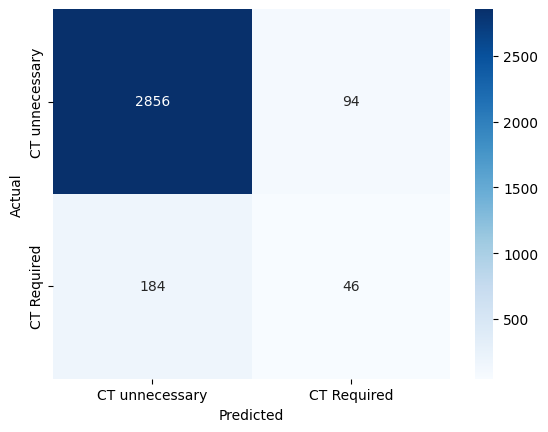

In [45]:
plt.figure()
cm = confusion_matrix(y_test, y_pred)
classes=['CT unnecessary', 'CT Required']
sns.heatmap(cm, annot=True,xticklabels=classes, yticklabels=classes,cmap='Blues',fmt=".0f")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [46]:
# prompt: 感度と特異度を算出

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# 混同行列の取得
cm = confusion_matrix(y_test, y_pred)

# 感度（再現率）の計算
sensitivity = recall_score(y_test, y_pred)
print("感度:", sensitivity)

# 特異度の計算
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
print("特異度:", specificity)


感度: 0.2
特異度: 0.9681355932203389


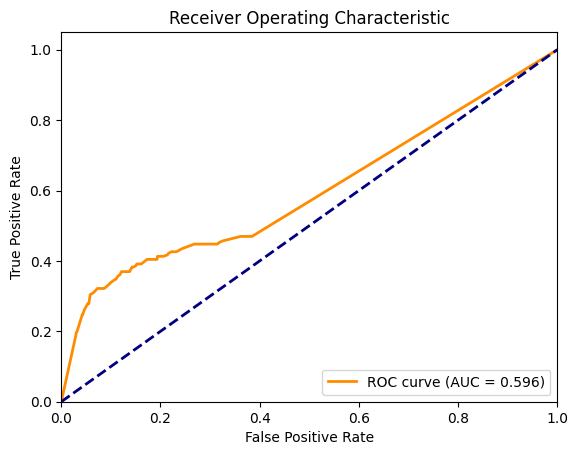

In [47]:
# prompt: ROC曲線とAUC

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ROC曲線の作成
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:, 1])

# AUCの計算
roc_auc = auc(fpr, tpr)

# ROC曲線のプロット
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# ベースラインで感度0.2、特異度0.968、AUC0.596のモデルが作成できました。よりよいモデルを構築して、ご報告をお待ちしております！